# Deep Learning Hello World

Basic examples for Tensorflow, Pytorch and JAX-based neural networks

In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
from matplotlib import pyplot as plt
from tabulate import tabulate
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor, LGBMClassifier

import tensorflow as tf
import torch
from torch.utils.data import Dataset, DataLoader
import jax
from jax import numpy as jnp
from jax import jit as jjit
import haiku as hk

# Feedforward 1: Linear Regression
- 1 hidden layer with ReLU activation
- MSE loss
- SGD optimization
- No minibatch (all data per batch)
- Training on CPU

In [2]:
n = 100
p = 3
train_rate = 0.7

X = np.random.normal(0, 1, size=(n, p))
y = np.sum(X, axis=1) + np.random.normal(0, 0.5, size=n)
print(tabulate(X[-3:], floatfmt='.4f'))
print(tabulate(y[-3:, np.newaxis], floatfmt='.4f'))

n_train = int(n*train_rate)

X_train = X[:n_train]
y_train = y[:n_train]
X_test = X[n_train:]
y_test = y[n_train:]

-------  ------  -------
-1.0078  1.4990   0.0467
-0.6960  1.5202   1.2099
 0.1050  0.7944  -0.0099
-------  ------  -------
------
0.0159
0.9749
1.5713
------


## Baseline: Linear Regression

In [3]:
model = LinearRegression()
model.fit(X_train, y_train)
print(f'Train {np.sqrt(mean_squared_error(y_train, model.predict(X_train))):.3f}')
print(f'Test  {np.sqrt(mean_squared_error(y_test, model.predict(X_test))):.3f}')

Train 0.520
Test  0.552


## TF2

- https://www.tensorflow.org/tutorials/keras/regression
- https://www.tensorflow.org/guide/keras/train_and_evaluate

In [4]:
def init_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(p, activation='relu', input_shape=(p,)),
        tf.keras.layers.Dense(1),
    ])

    model.compile(
        loss='mse',
        optimizer=tf.keras.optimizers.SGD(0.01),
        metrics=['mae', 'mse'],
    )
    
    return model

model = init_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 3)                 12        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 4         
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________


CPU times: user 18.8 s, sys: 460 ms, total: 19.3 s
Wall time: 17.1 s


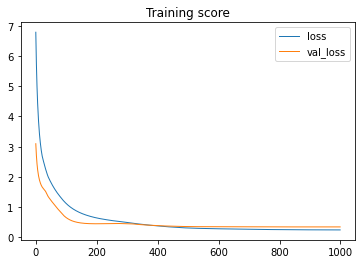

In [5]:
%%time
train_history = model.fit(
    X_train, 
    y_train,
    batch_size=n,
    epochs=1000, 
    validation_split=0.2, 
    verbose=0,
)
_ = pd.DataFrame(train_history.history)[['loss', 'val_loss']].plot(title='Training score', lw=1)

In [6]:
print(f'Train loss {np.sqrt(mean_squared_error(y_train, model.predict(X_train))):.3f}')
print(f'Test loss  {np.sqrt(mean_squared_error(y_test, model.predict(X_test))):.3f}')

Train loss 0.514
Test loss  0.571


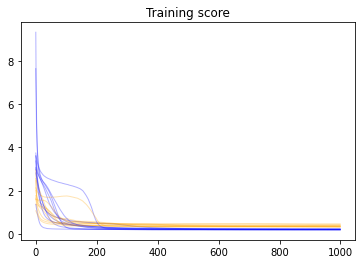

In [7]:
# Model variance
fig, ax = plt.subplots()

for i in range(10):
    model = init_model()

    train_history = model.fit(
        X_train, 
        y_train,
        epochs=1000, 
        validation_split=0.2, 
        verbose=0,
    )
    _ = pd.DataFrame(train_history.history)[['loss', 'val_loss']].plot(
        title='Training score', lw=1, ax=ax, 
        legend=False, color=['blue', 'orange'], alpha=0.3,
    )

## PyTorch


https://towardsdatascience.com/pytorch-tabular-regression-428e9c9ac93

In [8]:
def init_model():
    model = torch.nn.Sequential(
        torch.nn.Linear(p, p),
        torch.nn.ReLU(),
        torch.nn.Linear(p, 1),
    )

    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    loss_func = torch.nn.MSELoss()
    
    return model, optimizer, loss_func

model, optimizer, loss_func = init_model()

print(model)

Sequential(
  (0): Linear(in_features=3, out_features=3, bias=True)
  (1): ReLU()
  (2): Linear(in_features=3, out_features=1, bias=True)
)


CPU times: user 322 ms, sys: 12.3 ms, total: 334 ms
Wall time: 329 ms


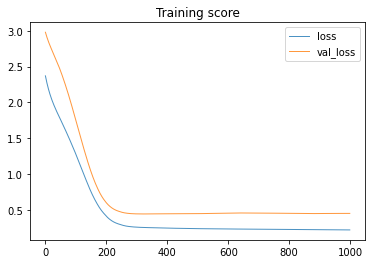

In [9]:
%%time
train_history = defaultdict(list)
X_train_1, X_train_2, y_train_1, y_train_2 = train_test_split(X_train, y_train, train_size=0.8)
inputs = torch.from_numpy(X_train_1).float()
outputs = torch.from_numpy(y_train_1[:, np.newaxis]).float()
val_inputs = torch.from_numpy(X_train_2).float()
val_outputs = torch.from_numpy(y_train_2[:, np.newaxis]).float()

for epoch in range(1000):
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs_hat = model(inputs)
    loss = loss_func(outputs_hat, outputs)
    loss.backward()
    optimizer.step()
    
    # save training loss
    train_history['loss'].append(loss.item())
    
    # compute validation loss
    with torch.no_grad():
        val_outputs_hat = model(val_inputs)
        val_loss = loss_func(val_outputs_hat, val_outputs)
        train_history['val_loss'].append(val_loss.item())

_ = pd.DataFrame(train_history).plot(title='Training score', lw=1, alpha=0.8)

In [10]:
print(f'Train {np.sqrt(mean_squared_error(y_train, model(torch.from_numpy(X_train).float()).detach().numpy())):.3f}')
print(f'Test  {np.sqrt(mean_squared_error(y_test, model(torch.from_numpy(X_test).float()).detach().numpy())):.3f}')

Train 0.516
Test  0.513


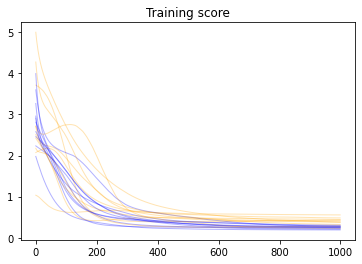

In [11]:
# Model variance
fig, ax = plt.subplots()

for i in range(10):
    model, optimizer, loss_func = init_model()
    
    train_history = defaultdict(list)
    X_train_1, X_train_2, y_train_1, y_train_2 = train_test_split(X_train, y_train, train_size=0.8)
    inputs = torch.from_numpy(X_train_1).float()
    outputs = torch.from_numpy(y_train_1[:, np.newaxis]).float()
    val_inputs = torch.from_numpy(X_train_2).float()
    val_outputs = torch.from_numpy(y_train_2[:, np.newaxis]).float()
    for epoch in range(1000):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs_hat = model(inputs)
        loss = loss_func(outputs_hat, outputs)
        loss.backward()
        optimizer.step()

        # save training loss
        train_history['loss'].append(loss.item())

        # compute validation loss
        with torch.no_grad():
            val_outputs_hat = model(val_inputs)
            val_loss = loss_func(val_outputs_hat, val_outputs)
            train_history['val_loss'].append(val_loss.item())
    
    _ = pd.DataFrame(train_history)[['loss', 'val_loss']].plot(
        title='Training score', lw=1, ax=ax, 
        legend=False, color=['blue', 'orange'], alpha=0.3,
    )
    

## Haiku

- https://github.com/deepmind/dm-haiku
- https://github.com/deepmind/dm-haiku/blob/master/examples/mnist.py

In [12]:
@jjit
def mse(outputs, outputs_hat):
    return (outputs-outputs_hat)**2

# @jjit
def loss_fn(inputs, outputs):
    mlp = hk.Sequential([
        hk.Linear(p), 
        jax.nn.relu,
        hk.Linear(1),
    ])
    outputs_hat = mlp(inputs)
    return jnp.mean(jnp.mean(mse(outputs, outputs_hat)))

# hk.transform allows us to turn this function into a pair of pure functions: init and apply. 
# All JAX transformations require to pass in a pure function for correct behaviour.
# Haiku makes it easy to write them.
loss_obj = hk.transform(loss_fn, apply_rng=True)

# Initial parameter values are typically random. In JAX you need a key in order
# to generate random numbers and so Haiku requires you to pass one in.
rng = jax.random.PRNGKey(42)

# `init` runs your function, as such we need an example input. Typically you can
# pass "dummy" inputs (e.g. ones of the same shape and dtype) since initialization
# is not usually data dependent.
X_train_1, X_train_2, y_train_1, y_train_2 = train_test_split(X_train, y_train, train_size=0.8)
X_train_1_ = jnp.asarray(X_train_1)
y_train_1_ = jnp.asarray(y_train_1[:, np.newaxis])
X_train_2_ = jnp.asarray(X_train_2)
y_train_2_ = jnp.asarray(y_train_2[:, np.newaxis])
X_test_ = jnp.asarray(X_test)
y_test_ = jnp.asarray(y_test[:, np.newaxis])

# The result of `init` is a nested data structure of all the parameters in your
# network. You can pass this into `apply`.
params = loss_obj.init(rng, X_train_1_, y_train_1_)
print(params)

# Gradient update
@jjit
def sgd(param, update):
    return param - 0.01 * update

/home/nameless/dev/vfenv/ds/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


frozendict({
  'linear': frozendict({
              'b': DeviceArray([0., 0., 0.], dtype=float32),
              'w': DeviceArray([[-0.85853237,  0.12908897, -0.13488792],
                                [ 0.24561784, -0.20738742,  0.15554754],
                                [-0.06070174,  0.3124922 ,  0.18682341]], dtype=float32),
            }),
  'linear_1': frozendict({
                'b': DeviceArray([0.], dtype=float32),
                'w': DeviceArray([[ 0.37143728],
                                  [-0.6535752 ],
                                  [ 0.5136476 ]], dtype=float32),
              }),
})


CPU times: user 11.2 s, sys: 687 ms, total: 11.9 s
Wall time: 9.3 s


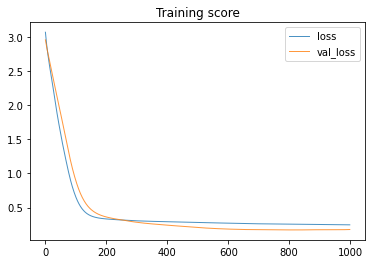

In [13]:
%%time

train_history = defaultdict(list)
for epoch in range(1000):
    # The `apply` function allows you to inject parameter values into your function.
#     grads = jax.grad(loss_obj.apply)(params, None, X_train_, y_train_)
#     loss = loss_obj.apply(params, None, X_train_, y_train_)
    loss, grads = jax.value_and_grad(loss_obj.apply)(params, None, X_train_1_, y_train_1_)
    params = jax.tree_multimap(sgd, params, grads)
    
    # Record train loss
    loss = float(jax.device_get(loss))
    train_history['loss'].append(loss)
    
    val_loss = loss_obj.apply(params, None, X_train_2_, y_train_2_)
    val_loss = float(jax.device_get(val_loss))
    train_history['val_loss'].append(val_loss)
    
_ = pd.DataFrame(train_history).plot(title='Training score', lw=1, alpha=0.8)

In [14]:
print(f'Train loss {np.sqrt(loss_obj.apply(params, None, X_train_1_, y_train_1_)):.3f}')
print(f'Test loss  {np.sqrt(loss_obj.apply(params, None, X_test_, y_test_)):.3f}')

Train loss 0.499
Test loss  0.627


In [15]:
# Model variance
# TODO

## Flax

https://github.com/google/flax

In [16]:
# TODO

# Feedforward 2: Non-linear Regression
- 2 hidden layers with ReLU activation
- MSE loss
- SGD optimization
- Minibatch (10/100/1000/10000 samples)
- Training on CPU

In [17]:
n = 10000
p = 3
train_rate = 0.7

X = np.random.normal(0, 1, size=(n, p))
y = np.sum(X[:, :-2] * X[:, 1:-1], axis=1)  + np.random.normal(0, 0.5, size=n)
print(tabulate(X[-3:], floatfmt='.4f'))
print(tabulate(y[-3:, np.newaxis], floatfmt='.4f'))

n_train = int(n*train_rate)

X_train = X[:n_train]
y_train = y[:n_train]
X_test = X[n_train:]
y_test = y[n_train:]

-------  -------  -------
 1.2684   0.0884  -0.5057
 0.8222  -0.1279  -0.6212
-0.3168  -0.5876  -0.9423
-------  -------  -------
-------
 0.5697
-0.2283
 0.2594
-------


## Baseline: Gradient Boosting

In [18]:
model = LGBMRegressor(
    n_estimators=1000, 
    min_data_in_leaf=10,
    learning_rate=0.01,
    objective='regression',
)

model.fit(X_train, y_train)
print(f'Train loss {np.sqrt(mean_squared_error(y_train, model.predict(X_train))):.3f}')
print(f'Test loss  {np.sqrt(mean_squared_error(y_test, model.predict(X_test))):.3f}')

Train loss 0.443
Test loss  0.521


## TF2

Train loss 0.493
Test loss  0.508
CPU times: user 4min 20s, sys: 26.2 s, total: 4min 46s
Wall time: 2min 53s


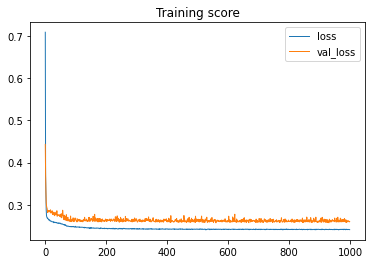

In [19]:
%%time

def train_model(X_train, y_train, batch_size):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(7, activation='relu', input_shape=(p,)),
        tf.keras.layers.Dense(7, activation='relu'),
        tf.keras.layers.Dense(1),
    ])

    model.compile(
        loss='mse',
        optimizer=tf.keras.optimizers.SGD(0.01),
        metrics=['mae', 'mse'],
    )

    train_history = model.fit(
        X_train, 
        y_train,
        batch_size=batch_size,
        epochs=1000, 
        validation_split=0.2, 
        verbose=0,
    )
    return model, train_history

# batch size = 10
model, train_history = train_model(X_train, y_train, batch_size=10)
_ = pd.DataFrame(train_history.history)[['loss', 'val_loss']].plot(title='Training score', lw=1)
print(f'Train loss {np.sqrt(mean_squared_error(y_train, model.predict(X_train))):.3f}')
print(f'Test loss  {np.sqrt(mean_squared_error(y_test, model.predict(X_test))):.3f}')

Train loss 0.496
Test loss  0.508
CPU times: user 1min, sys: 5.8 s, total: 1min 6s
Wall time: 36.6 s


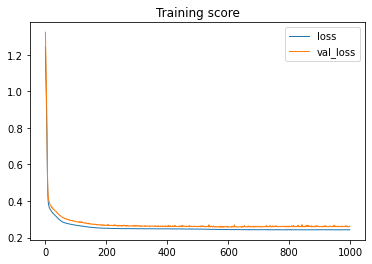

In [20]:
%%time
# batch size = 100
model, train_history = train_model(X_train, y_train, batch_size=100)
_ = pd.DataFrame(train_history.history)[['loss', 'val_loss']].plot(title='Training score', lw=1)
print(f'Train loss {np.sqrt(mean_squared_error(y_train, model.predict(X_train))):.3f}')
print(f'Test loss  {np.sqrt(mean_squared_error(y_test, model.predict(X_test))):.3f}')

Train loss 0.506
Test loss  0.511
CPU times: user 24.9 s, sys: 1.01 s, total: 25.9 s
Wall time: 20 s


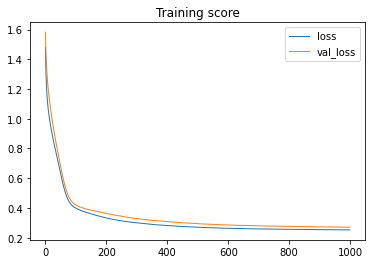

In [21]:
%%time
# batch size = 1000
model, train_history = train_model(X_train, y_train, batch_size=1000)
_ = pd.DataFrame(train_history.history)[['loss', 'val_loss']].plot(title='Training score', lw=1)
print(f'Train loss {np.sqrt(mean_squared_error(y_train, model.predict(X_train))):.3f}')
print(f'Test loss  {np.sqrt(mean_squared_error(y_test, model.predict(X_test))):.3f}')

Train loss 0.544
Test loss  0.542
CPU times: user 19.7 s, sys: 546 ms, total: 20.2 s
Wall time: 17.4 s


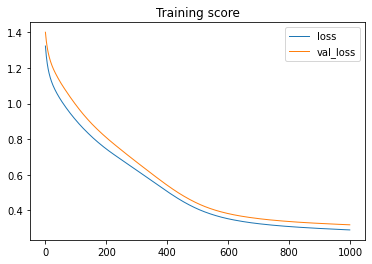

In [22]:
%%time
# batch size = 10000
model, train_history = train_model(X_train, y_train, batch_size=10000)
_ = pd.DataFrame(train_history.history)[['loss', 'val_loss']].plot(title='Training score', lw=1)
print(f'Train loss {np.sqrt(mean_squared_error(y_train, model.predict(X_train))):.3f}')
print(f'Test loss  {np.sqrt(mean_squared_error(y_test, model.predict(X_test))):.3f}')

## PyTorch

In [23]:
class PrepareData(Dataset):
    def __init__(self, X, y):
        if not torch.is_tensor(X):
            X = torch.from_numpy(X).float()
        if not torch.is_tensor(y):
            y = torch.from_numpy(y[:, np.newaxis]).float()
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

Train 0.491
Test  0.504
CPU times: user 3min 37s, sys: 3.88 s, total: 3min 41s
Wall time: 3min 39s


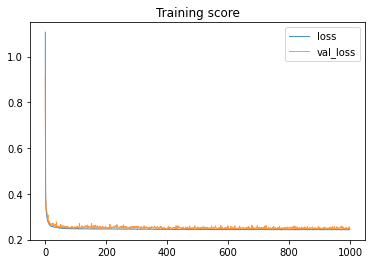

In [24]:
%%time

def train_model(X_train, y_train, batch_size):
    model = torch.nn.Sequential(
        torch.nn.Linear(p, 7),
        torch.nn.ReLU(),
        torch.nn.Linear(7, 7),
        torch.nn.ReLU(),
        torch.nn.Linear(7, 1),
    )

    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    loss_func = torch.nn.MSELoss()

    X_train_1, X_train_2, y_train_1, y_train_2 = train_test_split(X_train, y_train, train_size=0.8)
    train_loader = DataLoader(PrepareData(X_train_1, y=y_train_1), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(PrepareData(X_train_2, y=y_train_2), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(PrepareData(X_test, y=y_test), batch_size=batch_size, shuffle=True)
    train_history = defaultdict(list)
    
    for epoch in range(1000):
        loss_c = 0
        for X_train_batch, y_train_batch in train_loader:
            optimizer.zero_grad()
            y_train_batch_hat = model(X_train_batch)
            loss = loss_func(y_train_batch_hat, y_train_batch)
            loss.backward()
            optimizer.step()
            loss_c += loss.item()
        train_history['loss'].append(loss_c/len(train_loader))

        with torch.no_grad():
            val_loss_c = 0
            for X_val_batch, y_val_batch in val_loader:
                y_val_batch_hat = model(X_val_batch)
                val_loss = loss_func(y_val_batch_hat, y_val_batch)
                val_loss_c += val_loss.item()
            train_history['val_loss'].append(val_loss_c/len(val_loader))
    return model, train_history

# batch size = 10
model, train_history = train_model(X_train, y_train, batch_size=10)
_ = pd.DataFrame(train_history).plot(title='Training score', lw=1, alpha=0.8)
print(f'Train {np.sqrt(mean_squared_error(y_train, model(torch.from_numpy(X_train).float()).detach().numpy())):.3f}')
print(f'Test  {np.sqrt(mean_squared_error(y_test, model(torch.from_numpy(X_test).float()).detach().numpy())):.3f}')

Train 0.505
Test  0.515
CPU times: user 45.7 s, sys: 349 ms, total: 46.1 s
Wall time: 45.8 s


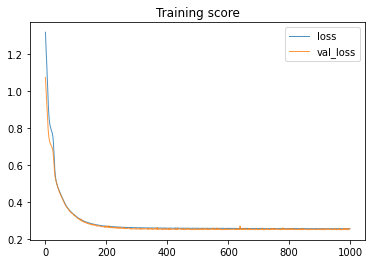

In [25]:
%%time
# batch size = 100
model, train_history = train_model(X_train, y_train, batch_size=100)
_ = pd.DataFrame(train_history).plot(title='Training score', lw=1, alpha=0.8)
print(f'Train {np.sqrt(mean_squared_error(y_train, model(torch.from_numpy(X_train).float()).detach().numpy())):.3f}')
print(f'Test  {np.sqrt(mean_squared_error(y_test, model(torch.from_numpy(X_test).float()).detach().numpy())):.3f}')

Train 0.509
Test  0.512
CPU times: user 3min 11s, sys: 0 ns, total: 3min 11s
Wall time: 35.3 s


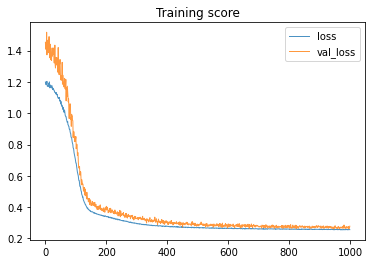

In [26]:
%%time
# batch size = 1000
model, train_history = train_model(X_train, y_train, batch_size=1000)
_ = pd.DataFrame(train_history).plot(title='Training score', lw=1, alpha=0.8)
print(f'Train {np.sqrt(mean_squared_error(y_train, model(torch.from_numpy(X_train).float()).detach().numpy())):.3f}')
print(f'Test  {np.sqrt(mean_squared_error(y_test, model(torch.from_numpy(X_test).float()).detach().numpy())):.3f}')

Train 0.611
Test  0.598
CPU times: user 2min 50s, sys: 0 ns, total: 2min 50s
Wall time: 48.9 s


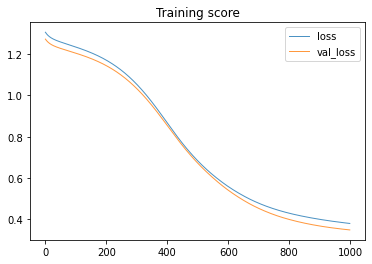

In [27]:
%%time
# batch size = 10000
model, train_history = train_model(X_train, y_train, batch_size=10000)
_ = pd.DataFrame(train_history).plot(title='Training score', lw=1, alpha=0.8)
print(f'Train {np.sqrt(mean_squared_error(y_train, model(torch.from_numpy(X_train).float()).detach().numpy())):.3f}')
print(f'Test  {np.sqrt(mean_squared_error(y_test, model(torch.from_numpy(X_test).float()).detach().numpy())):.3f}')

# Feedforward 3: Binary Classification
- 2 hidden layers with ReLU activation
- sigmoid output
- Cross-entropy / MSE loss
- SGD optimization
- Minibatch (100 samples)
- Training on CPU

In [28]:
n = 10000
p = 3
train_rate = 0.7

X = np.random.normal(0, 1, size=(n, p))
y = np.sum(X[:, :-2] * X[:, 1:-1], axis=1)  + np.random.normal(0, 0.5, size=n)
y = (y > 0).astype(float)
print(tabulate(X[-3:], floatfmt='.4f'))
print(tabulate(y[-3:, np.newaxis], floatfmt='.4f'))

n_train = int(n*train_rate)

X_train = X[:n_train]
y_train = y[:n_train]
X_test = X[n_train:]
y_test = y[n_train:]

-------  ------  -------
-0.1093  0.0880  -0.4328
 0.2456  0.5935   0.3300
-1.0127  0.3764  -0.5561
-------  ------  -------
------
1.0000
1.0000
0.0000
------


## Baseline: Gradient Boosting

In [29]:
model = LGBMClassifier(
    n_estimators=1000, 
    min_data_in_leaf=10,
    learning_rate=0.01,
    objective='cross_entropy',
)

model.fit(X_train, y_train)
print(f'Train score {accuracy_score(y_train, model.predict(X_train)):.3f}')
print(f'Test score  {accuracy_score(y_test, model.predict(X_test)):.3f}')

Train score 0.851
Test score  0.767


## TF2

https://www.tensorflow.org/tutorials/keras/classification

Train score 0.773
Test score  0.770
CPU times: user 59.4 s, sys: 4.82 s, total: 1min 4s
Wall time: 38.1 s


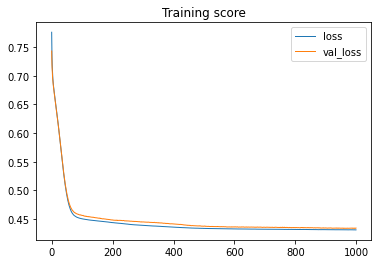

In [30]:
%%time

def train_model(X_train, y_train, loss, activation):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(7, activation='relu', input_shape=(p,)),
        tf.keras.layers.Dense(7, activation='relu'),
        tf.keras.layers.Dense(1, activation=activation),
    ])

    model.compile(
        loss=loss,
        optimizer=tf.keras.optimizers.SGD(0.01),
        metrics=['accuracy'],
    )

    train_history = model.fit(
        X_train, 
        y_train,
        batch_size=100,
        epochs=1000, 
        validation_split=0.2, 
        verbose=0,
    )
    return model, train_history

# cross-entropy + sigmoid
def decide(arr):
    return (arr > 0.5).astype(float)

model, train_history = train_model(X_train, y_train, loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), activation='sigmoid')
_ = pd.DataFrame(train_history.history)[['loss', 'val_loss']].plot(title='Training score', lw=1)
print(f'Train score {accuracy_score(y_train, decide(model.predict(X_train))):.3f}')
print(f'Test score  {accuracy_score(y_test, decide(model.predict(X_test))):.3f}')

Train score 0.771
Test score  0.774
CPU times: user 59.8 s, sys: 4.92 s, total: 1min 4s
Wall time: 37.1 s


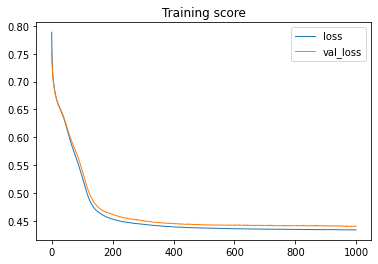

In [31]:
%%time

# cross-entropy (mod) + linear
def decide(arr):
    return (arr > 0.).astype(float)

model, train_history = train_model(X_train, y_train, loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), activation='linear')
_ = pd.DataFrame(train_history.history)[['loss', 'val_loss']].plot(title='Training score', lw=1)
print(f'Train score {accuracy_score(y_train, decide(model.predict(X_train))):.3f}')
print(f'Test score  {accuracy_score(y_test, decide(model.predict(X_test))):.3f}')

Train score 0.772
Test score  0.776
CPU times: user 59.9 s, sys: 5.13 s, total: 1min 5s
Wall time: 36.1 s


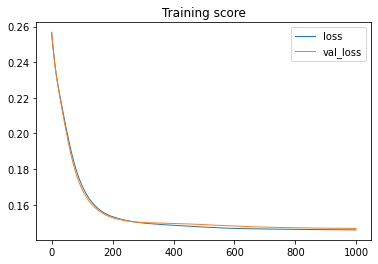

In [32]:
%%time

# mse + sigmoid
def decide(arr):
    return (arr > 0.5).astype(float)

model, train_history = train_model(X_train, y_train, loss='mse', activation='sigmoid')
_ = pd.DataFrame(train_history.history)[['loss', 'val_loss']].plot(title='Training score', lw=1)
print(f'Train score {accuracy_score(y_train, decide(model.predict(X_train))):.3f}')
print(f'Test score  {accuracy_score(y_test, decide(model.predict(X_test))):.3f}')

Train score 0.531
Test score  0.550
CPU times: user 58.7 s, sys: 5.17 s, total: 1min 3s
Wall time: 35.8 s


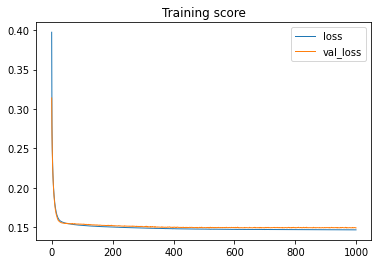

In [33]:
%%time

# mse + linear
def decide(arr):
    return (arr > 0.).astype(float)

model, train_history = train_model(X_train, y_train, loss='mse', activation='linear')
_ = pd.DataFrame(train_history.history)[['loss', 'val_loss']].plot(title='Training score', lw=1)
print(f'Train score {accuracy_score(y_train, decide(model.predict(X_train))):.3f}')
print(f'Test score  {accuracy_score(y_test, decide(model.predict(X_test))):.3f}')

## PyTorch

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [34]:
class PrepareData(Dataset):
    def __init__(self, X, y):
        if not torch.is_tensor(X):
            X = torch.from_numpy(X).float()
        if not torch.is_tensor(y):
            y = torch.from_numpy(y[:, np.newaxis]).float()
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

Train 0.772
Test  0.768
CPU times: user 46.9 s, sys: 495 ms, total: 47.4 s
Wall time: 47.1 s


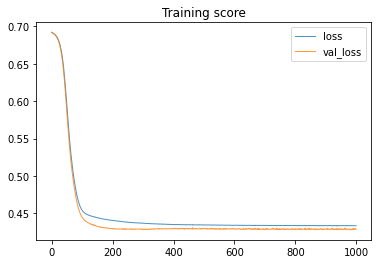

In [35]:
%%time
def train_model(X_train, y_train):
    model = torch.nn.Sequential(
        torch.nn.Linear(p, 7),
        torch.nn.ReLU(),
        torch.nn.Linear(7, 7),
        torch.nn.ReLU(),
        torch.nn.Linear(7, 1),
        torch.nn.Sigmoid(),
    )

    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    loss_func = torch.nn.BCELoss()

    X_train_1, X_train_2, y_train_1, y_train_2 = train_test_split(X_train, y_train, train_size=0.8)
    train_loader = DataLoader(PrepareData(X_train_1, y=y_train_1), batch_size=100, shuffle=True)
    val_loader = DataLoader(PrepareData(X_train_2, y=y_train_2), batch_size=100, shuffle=True)
    test_loader = DataLoader(PrepareData(X_test, y=y_test), batch_size=100, shuffle=True)
    train_history = defaultdict(list)
    
    for epoch in range(1000):
        loss_c = 0
        for X_train_batch, y_train_batch in train_loader:
            optimizer.zero_grad()
            y_train_batch_hat = model(X_train_batch)
            loss = loss_func(y_train_batch_hat, y_train_batch)
            loss.backward()
            optimizer.step()
            loss_c += loss.item()
        train_history['loss'].append(loss_c/len(train_loader))

        with torch.no_grad():
            val_loss_c = 0
            for X_val_batch, y_val_batch in val_loader:
                y_val_batch_hat = model(X_val_batch)
                val_loss = loss_func(y_val_batch_hat, y_val_batch)
                val_loss_c += val_loss.item()
            train_history['val_loss'].append(val_loss_c/len(val_loader))
    return model, train_history

def decide(arr):
    return (arr > 0.5).astype(float)

model, train_history = train_model(X_train, y_train)
_ = pd.DataFrame(train_history).plot(title='Training score', lw=1, alpha=0.8)
print(f'Train {accuracy_score(y_train, decide(model(torch.from_numpy(X_train).float()).detach().numpy())):.3f}')
print(f'Test  {accuracy_score(y_test, decide(model(torch.from_numpy(X_test).float()).detach().numpy())):.3f}')